<a href="https://colab.research.google.com/github/Koks-creator/PytorchCatsVsDogsCNN/blob/main/PytorchCatsVsDogsResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Sep 23 15:55:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Set environment to GPU**

In [2]:
from typing import Tuple, Union
from time import perf_counter
import glob
import os
from google.colab import files
from zipfile import ZipFile
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [3]:
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d tongpython/cat-and-dog

 96% 209M/218M [00:02<00:00, 115MB/s]
100% 218M/218M [00:02<00:00, 106MB/s]


In [5]:
TRAIN_PATH = "training_set/training_set"
TEST_PATH = "test_set/test_set"
TRAIN_CSV_PATH = "/content/train_data.csv"
TEST_CSV_PATH = "/content/test_data.csv"
MODEL_PATH = "catvsdog_resnet.pt"
ZIP_FILE_PATH = "/content/cat-and-dog.zip"
CLASSES = ["cat", "dog"]

# Hyper params
NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [6]:
with ZipFile(ZIP_FILE_PATH, 'r') as zipf:
    zipf.extractall()
    print("Done")

Done


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

**Prepare dataset**

In [9]:
def prepare_dataset_file(data_path: str, save: Union[str, bool]=False, limit_per_class: Union[str, bool]=False) -> pd.DataFrame:
    filenames = []
    paths = []
    classes_indexes = []

    for index, class_name in enumerate(os.listdir(data_path)):
        class_images = glob.glob(rf"{data_path}/{class_name}/*.jpg")
        if limit_per_class:
            class_images = class_images[:limit_per_class]

        print(f"Addiing: {class_name}")
        for image_path in tqdm(class_images):
            filename = os.path.split(image_path)[1]

            filenames.append(filename)
            paths.append(image_path)
            classes_indexes.append(index)

    df =  pd.DataFrame(
      {
          "Filename": filenames,
          "Path": paths,
          "ClassIndex": classes_indexes
      })

    if save:
      df.to_csv(save)

    return df

In [10]:
train_df = prepare_dataset_file(TRAIN_PATH, TRAIN_CSV_PATH, limit_per_class=False)
test_df = prepare_dataset_file(TEST_PATH, TEST_CSV_PATH, limit_per_class=False)

Addiing: dogs


100%|██████████| 4005/4005 [00:00<00:00, 675575.61it/s]


Addiing: cats


100%|██████████| 4000/4000 [00:00<00:00, 359740.46it/s]


Addiing: dogs


100%|██████████| 1012/1012 [00:00<00:00, 305897.64it/s]


Addiing: cats


100%|██████████| 1011/1011 [00:00<00:00, 308418.16it/s]


In [11]:
class ImageDataset(Dataset):
    def __init__(self, root_data_path: str, delimiter=",", transform=None) -> None:
        self.root_data_path = root_data_path
        self.transform = transform
        self.delimiter = delimiter

        self.df = pd.read_csv(root_data_path, delimiter=delimiter)

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        row = self.df.loc[index]

        class_index = row.ClassIndex
        image_path = row.Path

        img = cv2.imread(image_path)
        if self.transform:
            img = self.transform(img)

        return img, torch.from_numpy(np.array(class_index, dtype=np.int64))

    def __len__(self) -> int:
        return len(self.df)

In [12]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [13]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize(mean, std)
])

In [14]:
train_dataset = ImageDataset(TRAIN_CSV_PATH, transform=data_transforms)
test_dataset = ImageDataset(TEST_CSV_PATH, transform=data_transforms)

In [15]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=2)

In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [17]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

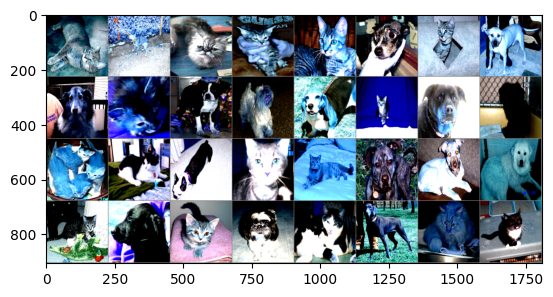

In [18]:
imshow(torchvision.utils.make_grid(images))

In [19]:
def get_test_accuracy(data_loader: DataLoader, model, loss_function) -> Tuple[float, float]:
    n_correct = 0
    n_samples = 0
    test_loss = 0

    model.eval()

    with torch.no_grad():
        for images, labels in train_loader:
            images = images.float().to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            test_loss  = loss_function(outputs, labels.unsqueeze(1))

            predictions = torch.sigmoid(outputs)
            rounded_predictions = torch.round(predictions)

            n_samples += labels.size(0)
            n_correct += (rounded_predictions.squeeze() == labels).sum().item()

    model.train()
    return 100 * n_correct/n_samples, test_loss

In [20]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.5MB/s]


In [21]:
model.fc = nn.Linear(num_ftrs, 1)

In [22]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [24]:
def train_model(model: torchvision.models.resnet.ResNet, criterion: torch.nn.modules.loss.BCEWithLogitsLoss,
                optimizer: torch.optim.Adam, num_epochs: int,
                train_loader: DataLoader, test_loader: DataLoader, device: torch.device) -> Tuple[torchvision.models.resnet.ResNet, list, list, list, list]:
    n_total_steps = len(train_loader)

    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(num_epochs):
        epoch_train_loss_values = []
        epoch_test_loss_values = []
        epoch_train_accuracy_values = []
        epoch_test_accuracy_values = []


        num_correct_train = 0
        num_samples_train = 0
        print(f"------------------- EPOCH {epoch+1}/{num_epochs} -------------------")
        for index, (train_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            train_images = train_images.to(device).float()
            train_labels = train_labels.to(device).float()

            # forward pass
            outputs = model(train_images)
            loss = criterion(outputs, train_labels.unsqueeze(1))

            # Calculate train accuracy
            with torch.no_grad():
                predictions = torch.sigmoid(outputs)
                rounded_train_preds = torch.round(predictions)
                # print(rounded_train_preds.shape)

                num_correct_train += torch.sum(rounded_train_preds.squeeze() == train_labels)
                num_samples_train += len(train_labels)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_history.append(epoch_train_loss_values)
        test_loss_history.append(epoch_test_loss_values)
        train_accuracy_history.append(epoch_train_accuracy_values)
        test_accuracy_history.append(epoch_test_accuracy_values)


        # Display epoch summary
        train_acc = 100 * num_correct_train / num_samples_train
        test_acc, test_loss = get_test_accuracy(test_loader, model, criterion)

        print(f'\nEpoch [{epoch+1}/{num_epochs}] Step [{index+1}/{n_total_steps}] Loss: {loss.item():.4f}, Test loss: {test_loss:.4f} | Acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

        epoch_train_loss_values.append(loss.item())
        epoch_test_loss_values.append(test_loss.item())
        epoch_train_accuracy_values.append(train_acc)
        epoch_test_accuracy_values.append(test_acc)


    print("Training finished")

    return model, train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history

In [26]:
model, train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history = train_model(model=model,
                                                                                                          criterion=criterion,
                                                                                                          optimizer=optimizer,
                                                                                                          num_epochs=NUM_EPOCHS,
                                                                                                          train_loader=train_loader,
                                                                                                          test_loader=test_loader,
                                                                                                          device=device)

------------------- EPOCH 1/10 -------------------


100%|██████████| 251/251 [00:53<00:00,  4.68it/s]



Epoch [1/10] Step [251/251] Loss: 0.0876, Test loss: 0.0235 | Acc: 92.5671, Test acc: 96.2648
------------------- EPOCH 2/10 -------------------


100%|██████████| 251/251 [00:42<00:00,  5.84it/s]



Epoch [2/10] Step [251/251] Loss: 0.0266, Test loss: 0.1067 | Acc: 95.5653, Test acc: 96.7770
------------------- EPOCH 3/10 -------------------


100%|██████████| 251/251 [00:42<00:00,  5.86it/s]



Epoch [3/10] Step [251/251] Loss: 0.1491, Test loss: 0.0056 | Acc: 96.0650, Test acc: 96.9644
------------------- EPOCH 4/10 -------------------


100%|██████████| 251/251 [00:42<00:00,  5.87it/s]



Epoch [4/10] Step [251/251] Loss: 0.0912, Test loss: 0.0367 | Acc: 95.8526, Test acc: 97.1143
------------------- EPOCH 5/10 -------------------


100%|██████████| 251/251 [00:43<00:00,  5.83it/s]



Epoch [5/10] Step [251/251] Loss: 0.4302, Test loss: 0.0079 | Acc: 96.2024, Test acc: 97.3267
------------------- EPOCH 6/10 -------------------


100%|██████████| 251/251 [00:44<00:00,  5.66it/s]



Epoch [6/10] Step [251/251] Loss: 0.1847, Test loss: 0.1225 | Acc: 96.6396, Test acc: 97.5016
------------------- EPOCH 7/10 -------------------


100%|██████████| 251/251 [00:42<00:00,  5.88it/s]



Epoch [7/10] Step [251/251] Loss: 0.4452, Test loss: 0.3379 | Acc: 96.3773, Test acc: 97.6390
------------------- EPOCH 8/10 -------------------


100%|██████████| 251/251 [00:44<00:00,  5.60it/s]



Epoch [8/10] Step [251/251] Loss: 0.0093, Test loss: 0.7059 | Acc: 96.5896, Test acc: 97.5390
------------------- EPOCH 9/10 -------------------


100%|██████████| 251/251 [00:43<00:00,  5.80it/s]



Epoch [9/10] Step [251/251] Loss: 0.6652, Test loss: 0.1234 | Acc: 96.6771, Test acc: 97.4516
------------------- EPOCH 10/10 -------------------


100%|██████████| 251/251 [00:42<00:00,  5.88it/s]



Epoch [10/10] Step [251/251] Loss: 0.0034, Test loss: 0.0077 | Acc: 96.7146, Test acc: 97.6015
Training finished


In [27]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]

    for index, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        predictions = torch.sigmoid(outputs)
        rounded_predictions = torch.round(predictions)

        n_samples += labels.size(0)
        n_correct += torch.sum(rounded_predictions.squeeze() == labels).sum().item()

        if labels.size(0) == BATCH_SIZE:
            for i in range(BATCH_SIZE):
                label = labels[i]
                pred = rounded_predictions[i]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1


    acc = 100 * n_correct / n_samples
    print(acc)

    for i in range(2):
      print(n_class_samples[i])
      acc = 100.0 * n_class_correct[i] / n_class_samples[i]
      print(f'Accuracy of {CLASSES[i]}: {acc} %')

97.2318339100346
1012
Accuracy of cat: 97.43083003952569 %
1004
Accuracy of dog: 97.01195219123505 %


In [29]:
model_scripted = torch.jit.script(model)
model_scripted.save(MODEL_PATH)

In [30]:
model = torch.jit.load(MODEL_PATH)  # when using cpu add map_location=torch.device('cpu')
model.eval()

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
    )
    (1): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)

In [31]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize(mean, std),
    transforms.Resize((224, 224))
])

In [32]:
# images = glob.glob(r"/content/test_set/test_set/cats/*.jpg")
images = glob.glob(r"/content/test_set/test_set/dogs/*.jpg")
correct = 0

with torch.no_grad():
  for img_path in images:
      with Image.open(img_path) as im:
        custom_image_transformed = data_transforms(im)

      # custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

      custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
      custom_image_transformed = custom_image_transformed.to(device)

      prediction_raw = model(custom_image_transformed)
      prediction = torch.sigmoid(prediction_raw)
      rounded_prediciton = torch.round(prediction)


      if rounded_prediciton.item() == 0:  # 1 for cats and 0 for dogs
        correct += 1

print(f"{correct}/{len(images)}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


996/1012
